# **Pizza project**

**Introduction**

Au cours de notre exploration en apprentissage automatique, notre équipe a choisi un projet stimulant : la détection de toppings sur les pizzas. Ce défi a attiré notre attention en raison de sa pertinence. En tant qu'étudiants, notre objectif est de mettre en pratique les concepts de base que nous avons appris tout en acquérant une expérience concrète dans le domaine.

Ce projet offre une opportunité d'appliquer des stratégies simples d'apprentissage automatique, telles que l'apprentissage direct sur des images réduites. Nous cherchons à comprendre et à mettre en œuvre différentes approches, tout en évaluant notre modèle face à des données réelles et simulées. Ce rapport documentera notre processus d'analyse du problème, nos choix de solutions, l'implémentation de nos approches, et enfin, l'évaluation des résultats obtenus.

En tant qu'étudiants en cours d'apprentissage, nous sommes enthousiastes à l'idée de partager nos découvertes et d'explorer les défis pratiques de la détection de toppings sur les pizzas. Ce projet marque le début de notre parcours dans le domaine de l'apprentissage automatique, et notre rapport reflétera notre engagement à apprendre et à relever des défis techniques.

**Présentation générale du projet**

Notre projet vise à résoudre le défi stimulant de la détection de toppings sur les pizzas en utilisant une approche d'apprentissage automatique. La tâche consiste à identifier simultanément la présence de dix catégories différentes de toppings sur une seule image de pizza, ce qui introduit une complexité due à la nature multi-label du problème.

**Stratégie d'apprentissage utilisée**

Nous avons opté pour une stratégie d'apprentissage direct en utilisant un réseau de neurones convolutif (CNN), adapté spécifiquement à notre tâche. L'approche consiste à entraîner le modèle directement sur des images réduites de pizzas, où chaque image est annotée avec les labels multi-label correspondant aux toppings présents.

**Le choix du Dataset**

Dans le cadre de notre projet de détection de toppings sur pizzas, nous privilégions l'utilisation du dataset synthétique généré par pizzaGAN. Cette dataset, créée dans le contexte de l'évaluation de la méthode pizzaGAN, se compose d'images de pizzas au style clip-art, générées de manière synthétique. Ces images offrent un avantage significatif en éliminant le coût associé à l'annotation manuelle des données réelles. En plus de sa diversité obtenue sans contrainte budgétaire, la dataset synthétique fournit des informations détaillées sur la séquence d'ordonnancement des ingrédients et une segmentation multi-couche des pixels des toppings. Cette richesse d'informations renforce la capacité du modèle à apprendre des caractéristiques spécifiques, tandis que le choix de données synthétiques permet d'évaluer la capacité de généralisation du modèle dans des contextes variés. Ainsi, l'utilisation de cette dataset synthétique se révèle stratégique, offrant des avantages pratiques pour l'entraînement efficace du modèle tout en facilitant son évaluation dans des conditions diversifiées.

## Connection to your drive


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/teaching/pizza'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).



Le code fourni utilise Google Colab, une plateforme cloud, pour monter Google Drive et accéder à des données stockées dans le répertoire '/content/gdrive/MyDrive/teaching/pizza'. La variable **DATA_DIR** est définie pour indiquer le chemin vers le répertoire des données sur Google Drive. Cela permet au code ultérieur d'accéder facilement aux fichiers dans ce répertoire.

# Useful libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

Cette cellule de code importe différentes bibliothèques nécessaires pour le projet:

**Manipulation de données** : **pandas** et **numpy** pour travailler avec des
données tabulaires et des opérations numériques.

**Manipulation de fichiers et système d'exploitation** : **os** pour les opérations sur les fichiers et **shutil** pour des opérations plus avancées (actuellement commenté).

**Visualisation** : **matplotlib** et **seaborn** pour créer des graphiques et visualisations.

**Traitement d'images** :**PIL**  (Pillow) pour manipuler des images.

**Suivi de progression** : **tqdm** pour afficher des barres de progression pendant l'exécution du code.

**Gestion des avertissements** : **warnings** pour gérer les avertissements émis par le code.

**Machine Learning** : **scikit-learn** pour les outils de machine learning classiques.

**Deep Learning** : **torch** et **torchvision** pour le développement d'applications d'apprentissage en profondeur.

**Calcul GPU : torch.cuda** et **nvidia-smi** pour vérifier et utiliser une GPU CUDA pour accélérer les calculs.

# Managing data



## Decompress the archive on Gdrive (rather than on your own desktop)


In [ ]:
#!unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/teaching/pizza/'

Cette étape utilise la commande unzip pour extraire le contenu de l'archive **pizzaGANsyntheticdata.zip** du répertoire spécifié vers le même répertoire, permettant ainsi l'accès aux données synthétiques pour le projet.

# Read Data

and build the train and test dataset

In [ ]:
#chargement des étiquettes d'entrainement
y_all = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/train/trainLabels.txt'))
#création des indices pour les images
x_all = np.arange(y_all.shape[0])



# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

#affichage de la forme des étiquettes d'entrainement
print(y_train.shape)

#chargement des étiquettes de test
y_test = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/test/testLabels.txt'))
x_test = np.arange(y_test.shape[0])

#Affichage de la forme des étiquettes de test
print(y_test.shape)

Ces étapes du code préparent les données en séparant les indices des images en ensembles d'entraînement, de validation et de test, ainsi qu'en chargeant les étiquettes correspondantes à partir de fichiers texte.

# Display one sample image

In [ ]:
#selection d'une image spécifique dans notre ensemble de données
idx = 45

#géneration du le nom de fichier de l'image en formatant l'index avec quatre chiffres, puis en ajoutant l'extension ".png".
img_name = "{:04d}.png".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

pour sélectionner une autre image, il suffit simplement de changer la valeur de l'index idx

# Store train images in memory


This should make learning faster.

In [ ]:
train_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  for idx in tqdm(x_all):
      img_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all))

cette cellule vérifie si un fichier numpy prétraité des images d'entraînement existe déjà. Si c'est le cas, il le charge. Sinon, il parcourt les images d'entraînement, les prétraite en les redimensionnant, les convertit en tableau NumPy, puis les sauvegarde dans un fichier numpy pour une utilisation ultérieure. Cette étape de prétraitement sert à accélérer le processus d'entraînement en évitant de recalculer les transformations d'image à chaque itération.

# Dataset class

In [ ]:
class myDataset(Dataset):
    """Pizza dataset"""

    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data

    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y

    def __len__(self):
        return int(len(self.x_idx))

Cette classe **myDataset** permet de créer un ensemble de données personnalisé qui va être utilisé avec les utilitaires de chargement de données de **PyTorch (**DataLoader) pour l'entraînement de modèles d'apprentissage en profondeur. Elle encapsule la logique de chargement des images et des étiquettes, ainsi que la possibilité d'appliquer des transformations d'image .

# Data loaders

In [ ]:
#ajustement des paramètres des chargeurs de données
batch_size = 25 #Taille des mini-lots lors de l'entraînement.

input_size = 224 #Taille d'entrée attendue pour les images.

#Normalisation des images
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

#Transformation pour l'entraînement et la validation
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])

#kwargs: Dictionnaire contenant des paramètres supplémentaires pour les chargeurs de données.
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')


img_all = np.array(img_all)
img_data_train = img_all[x_train, :, :, :]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

img_data_val = img_all[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

- Dans le code, la selection des paramètres des chargeurs de données a été effectuée pour optimiser l'apprentissage du modèle. La taille du lot a été ajustée pour s'adapter à la mémoire tout en accélérant l'entraînement, et des transformations d'augmentation ont été appliquées pour renforcer la robustesse. Les ajustements du nombre de travailleurs et l'épinglage en mémoire ont été configurés pour optimiser le chargement des données, favorisant ainsi la stabilité de l'entraînement, une convergence rapide, et une meilleure généralisation. C'est une approche itérative qui tient compte du contexte du problème et des ressources disponibles.

- La normalisation des images dans le code que fourni est réalisée à l'aide de la fonction **transforms.Normalize** de PyTorch, qui applique la formule mathématique suivante pour chaque canal RVB :

$$ X_{\text{normalized}} = \frac{X - \text{mean}}{\text{std}} $$

-   X normalised est la valeur normalisée,
X est la valeur originale du pixel,
mean est la moyenne des valeurs du pixel sur l'ensemble de données, et std est l'écart type des valeurs du pixel sur l'ensemble de données.

- Cette normalisation vise à centrer les valeurs des pixels autour de zéro en soustrayant la moyenne et à rendre les valeurs plus comparables en les divisant par l'écart type. Ces étapes contribuent à une formation plus stable, à une convergence plus rapide et à une meilleure généralisation du modèle.

# Visualize data loader

In [ ]:
# Show dataset sample
x,y = test_set_raw[45]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

cette cellule permet de visualiser à la fois un échantillon individuel du jeu de données de test et un lot d'images du jeu de données d'entraînement. Cela offre une vérification visuelle rapide pour s'assurer que les données sont correctement chargées et prétraitées avant l'entraînement du modèle.

# Learning



## Compute deep features for images

Example of how to compute deep image features using a resnext network.

In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat_resnext.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from ".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
  resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

  if device.type == 'cuda':
      resnext = resnext.cuda()

  model = resnext

  # Removes the last classification layer: may different for other network
  modules=list(model.children())[:-1]
  model=nn.Sequential(*modules)
  for p in model.parameters():
      p.requires_grad = False

  # If you need to put the last layer back
  #num_ftrs = resnext.fc.in_features
  #resnext.fc = nn.Linear(num_ftrs, 9)

  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)



cette cellule démontre comment extraire des caractéristiques profondes d'un ensemble d'images à l'aide d'un modèle ResNeXt pré-entraîné, fournissant une représentation plus compacte et abstraite des images.

# Learning multi-label from pre-computed features

In [ ]:
# Use the same random seed to generate the same split
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat, y_all, test_size=0.2, random_state=123)

print(feat_train.shape)

# Chexks if labels are the same as the image split
print(np.all(y_val == yfeat_val))


# Simple network definition

In [ ]:
# network class
class SimpleCNN(nn.Module):
  def __init__(self, nlabel = 10, drop = 0):
    super(SimpleCNN, self).__init__()
    self.nlabel = nlabel
    self.drop = drop
    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.conv3 = nn.Conv2d(32,64,3)

    self.lin_input_size = self.calculate_conv_output_size()

    self.lin1 = nn.Linear(self.lin_input_size, 128)
    if (self.drop == 1):
      self.dropout = nn.Dropout(p=0.2)
    self.lin2 = nn.Linear(128, self.nlabel)

  def calculate_conv_output_size(self):
        # Dummy input to calculate the output size after the last convolution
        x = torch.randn(1, 3, 224, 224)
        x1 = self.conv1(x)
        x1r = F.relu(x1)
        x1p = F.max_pool2d(x1r, 2)

        x2 = self.conv2(x1p)
        x2r = F.relu(x2)
        x2p = F.max_pool2d(x2r, 2)

        x3 = self.conv3(x2p)
        x3r = F.relu(x3)
        x3p = F.max_pool2d(x3r, 2)

        return x3p.view(x3p.size(0), -1).size(1)

  def forward(self, x):

    # 32x32

    # define here the forward pass
    x1 = self.conv1(x)
    x1r = F.relu(x1)
    x1p = F.max_pool2d(x1r, 2)

    # 16x16
    x2 = self.conv2(x1p)
    x2r = F.relu(x2)
    x2p = F.max_pool2d(x2r, 2)

    # 8x8
    x3 = self.conv3(x2p)
    x3r = F.relu(x3)
    x3p = F.max_pool2d(x3r, 2)

    # 4x4
    y0 = x3p.view(x3p.size(0), -1)

    y1 = self.lin1(y0)
    y1r = F.relu(y1)
    if (self.drop == 1):
      y1d = self.dropout(y1)
    y2 = self.lin2(y1r)

    return y2


Ici on a ajouté un paramètre **drop** qui contrôle si le dropout doit être appliqué ou non. Si drop est égal à 1, alors le dropout est activé avec une probabilité de 0.2 (20%). Cela est utile pour régulariser le modèle et réduire le surapprentissage pendant l'entraînement.

Lors de l'entrainement ('**self**.**training**'):Si drop est égal à 1, alors le dropout est appliqué, sinon le modèle continue sans dropout.

celle-ci est formulé comme suit : 𝒳 l'entrée d'une couche et 𝒴 la sortie après l'application du dropout. Pendant l'entraînement, chaque élément de 𝒴 est calculé comme suit :

$$
y_i = \frac{x_i \cdot \text{Bernoulli}(p)}{1 - p}
$$

où *p* est la probabilité de dropout (la probabilité qu'un neurone soit désactivé), ici c'est 20% et Bernouilli(*p*)  est une variable aléatoire de Bernoulli avec une probabilité de succès *p*

En d'autres termes, pour chaque élément 𝒳i, on le conserve avec une probabilité 1-*p* et on le met à zéro avec une probabilité *p*. Lorsque le dropout est appliqué à chaque élément de l'entrée, cela revient à échantillonner plusieurs versions différentes du réseau pendant l'entraînement, ce qui contribue à la régularisation.

 L'idée principale du dropout est de désactiver aléatoirement un certain nombre de neurones pendant l'entraînement, ce qui oblige le réseau à apprendre des représentations plus robustes et à éviter une dépendance excessive à certains neurones spécifiques.

In [ ]:
nlabel = y_all.shape[1]

network = SimpleCNN(nlabel = nlabel)
# Name of the network
tag = "simpleCNN"

Le nombre de classes (**nlabel**) est déterminé à partir de la forme des étiquettes (**y_all**). Cela indique le nombre de classes dans notre problème de détection de toppings sur des images de pizzas.

# Learning

In [ ]:
#from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

import copy

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs = 5,test = 0):
    # list for saving accuracies
    train_perf = []
    test_perf = []
    train_losses = []
    matrix = np.zeros((num_epochs,10))
    loss_list = []
    test_matrix = np.zeros((num_epochs,10))
    # iterate over epochs
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))

        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # Convert labels to float

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track training statistics
            running_loss += loss.item()
            total_train += labels.size(0)

            binary_predictions = (outputs > 0.5).float()

            correct_train += (binary_predictions == labels).sum(dim=0).cpu().numpy()

        # Calculate training accuracy and loss
        train_accuracy = correct_train / total_train
        train_loss = running_loss / len(trainloader)
        loss_list.append(train_loss)
        train_losses.append(train_loss)
        train_perf = 1-train_accuracy
        for i in range(10):
          matrix[epoch][i]=train_accuracy[i]
        print("Training loss: ", train_loss)
        print("Training accuracy: ", train_accuracy)
        if (test==1):
          testloader = test_dataloader
          network=model
          # set the model to evaluation mode
          network.eval()

          # create the per
          perf_label_test = np.zeros((1,nlabel))

          # tell not to reserve memory space for gradients (much faster)
          with torch.no_grad():
              for inputs, targets in testloader:

                  inputs = inputs.to(device)
                  targets = targets.to(device)

                  # compute outputs
                  outputs = network(inputs)

                  outputs_np = outputs.cpu().detach().numpy()
                  targets_np = targets.cpu().detach().numpy()

                  # compute the predictions
                  pred = (outputs_np > 0)

                  # update the performance
                  perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

          # Prints the performance (per label)

          oa_test = perf_label_test / len(testloader.dataset)
          print(oa_test)
          for i in range(10):
            test_matrix[epoch][i] = oa_test[0][i]

    print("Training complete.")
      # Learning step
    return model, train_perf, test_perf, train_losses, matrix, loss_list ,test_matrix

- Les modifications apportées à la fonction **train_model_multilabel** visent à étendre ses fonctionnalités en ajoutant la possibilité de suivre la performance du modèle sur les données de test

- L'argument **test** est ajouté à la fonction pour permettre de contrôler si l'évaluation sur les données de test ou bien celle des données d'entrainement doit être effectuée après chaque époque. Par défaut, il est à 0 (évaluation de données d'entrainement)

- Deux matrices (**matrix** et **test_matrix**) sont ajoutées pour stocker la performance sur chaque époque pour chacune des 10 classes.

- Nouvelle boucle conditionnelle pour l'évaluation sur les données de test,Si test est égal à 1, la fonction évalue le modèle sur les données de test après chaque époque et stocke la performance dans test_matrix.

- Modification de la valeur retournée par la fonction,en plus du modèle entraîné, de la performance d'entraînement, des performances de test, des pertes d'entraînement et des listes de pertes.

- Ajout d'une boucle pour stocker la performance sur chaque classe

- Modifications mineures pour l'affichage et l'organisation du code.

En résumé, ces modifications permettent de suivre et d'évaluer la performance du modèle sur les données de test en plus des données d'entraînement, fournissant ainsi une vue plus complète de la performance du modèle sur l'ensemble du jeu de données.

# Training without droupout

In [ ]:
nlabel = y_all.shape[1]

network = SimpleCNN(nlabel = nlabel, drop = 1)
# Name of the network
tag = "simpleCNN"

In [ ]:
import torch.optim as optim
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

# Read the last learned network (if stored)
#if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    #print('Resume from last learning step')
    #network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler


# Learning
max_epoch = 20
learned_model, train_error, test_error, train_losses , matrix, loss_list , test_matrix = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# ploting accuracy for each characteristic

# Create some example data

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Create individual subplots
arg = [ 'Pepperoni', 'Mushroom', 'Pepper', 'Olive', 'Basil', 'Bacon', 'Brocoli', 'Pineapple', 'Tomato', 'Onion']
for i in range(10):
    x = matrix[:, i].tolist()
    y = range(1, max_epoch + 1)
    axes[i].plot(y, x , label=f'{arg[i]}')
    axes[i].set_title(f'{arg[i]}')
    axes[i].legend()

# Adjust layout to prevent subplot titles from overlapping
y = range(1, max_epoch + 1)
plt.tight_layout()
fig2, ax2 = plt.subplots(figsize=(6, 3))
ax2.plot(y, loss_list, 'b', label='Training loss')
ax2.set_title('Training loss')
ax2.legend()

# Show the plot
plt.show()
#network = learned_model

print("Train accuracies")
#print(train_error)
print("Test accuracies")
#print(test_error)
print("Train losses")
#print(train_losses)


1- **Courbes d'entraînement pour chaque caractéristique (classe) :**
- Chaque courbe représente l'évolution de l'exactitude d'entraînement pour une caractéristique spécifique (par exemple, Pepperoni, Mushroom, etc.) au fil des époques.
- Une croissance régulière de l'exactitude d'entraînement indique que le modèle apprend bien à identifier cette caractéristique.
- la croissance des courbes d'entraînement indique une convergence du modèle vers une meilleure performance au fur et à mesure de l'entraînement. Cela démontre que le réseau CNN apprend progressivement à extraire des caractéristiques discriminantes pour chaque classe spécifique dans les données d'entraînement.








2- **Courbe de perte d'entraînement :**
- La courbe de perte d'entraînement montre comment la perte du modèle sur les données d'entraînement évolue au fil des époques.
- Une décroissance régulière de la perte d'entraînement indique que le modèle s'ajuste aux données d'entraînement.

# Training with Droupout

In [ ]:
nlabel = y_all.shape[1]

network = SimpleCNN(nlabel = nlabel, drop = 1)
# Name of the network
tag = "simpleCNN"

In [ ]:
import torch.optim as optim
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

# Read the last learned network (if stored)
#if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    #print('Resume from last learning step')
    #network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler


# Learning
max_epoch = 20
learned_model, train_error, test_error, train_losses , matrix, loss_list , test_matrix = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# ploting accuracy for each characteristic

# Create some example data

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Create individual subplots
arg = [ 'Pepperoni', 'Mushroom', 'Pepper', 'Olive', 'Basil', 'Bacon', 'Brocoli', 'Pineapple', 'Tomato', 'Onion']
for i in range(10):
    x = matrix[:, i].tolist()
    y = range(1, max_epoch + 1)
    axes[i].plot(y, x , label=f'{arg[i]}')
    axes[i].set_title(f'{arg[i]}')
    axes[i].legend()

# Adjust layout to prevent subplot titles from overlapping
y = range(1, max_epoch + 1)
plt.tight_layout()
fig2, ax2 = plt.subplots(figsize=(6, 3))
ax2.plot(y, loss_list, 'b', label='Training loss')
ax2.set_title('Training loss')
ax2.legend()

# Show the plot
plt.show()
#network = learned_model

print("Train accuracies")
#print(train_error)
print("Test accuracies")
#print(test_error)
print("Train losses")
#print(train_losses)

**Comparaison des courbes avec et sans dropout :**

**1- Courbes d'entraînement pour chaque caractéristique :**

- **Sans Dropout** : Les courbes d'entraînement montrent des signes de surapprentissage si elles augmentent constamment, ce qui indique une adaptation excessive aux données d'entraînement.
- **Avec Dropout**: L'ajout de dropout introduit du bruit pendant l'entraînement, ce qui aide à prévenir le surapprentissage. Les courbes sont moins susceptibles de monter brusquement, indiquant une meilleure régularisation.

2- **Courbe de perte d'entraînement :**

- **Sans Dropout** : La courbe de perte diminue, mais elle est plus sujette au surapprentissage si elle atteint des valeurs très basses.
- **Avec Dropout** : L'ajout de dropout  entraîne une courbe de perte qui reste plus stable au fil des époques, contribuant à une meilleure généralisation.

 mathématiquement, le dropout introduit une forme de régularisation stochastique qui aide à prévenir le surapprentissage en introduisant du bruit et en forçant le réseau à être plus robuste.


# Final evaluation
An example of performance computation.

# test without dropout

In [ ]:
nlabel = y_all.shape[1]

network = SimpleCNN(nlabel = nlabel)
# Name of the network
tag = "simpleCNN"

In [ ]:
import torch.optim as optim
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

# Read the last learned network (if stored)
#if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    #print('Resume from last learning step')
    #network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler


# Learning
max_epoch = 20
learned_model, train_error, test_error, train_losses , matrix, loss_list ,test_matrix = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch,test=1)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# ploting accuracy for each characteristic

# Create some example data

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Create individual subplots
arg = [ 'Pepperoni', 'Mushroom', 'Pepper', 'Olive', 'Basil', 'Bacon', 'Brocoli', 'Pineapple', 'Tomato', 'Onion']
for i in range(10):
    x = test_matrix[:, i].tolist()
    y = range(1, max_epoch + 1)
    axes[i].plot(y, x , label=f'{arg[i]}')
    axes[i].set_title(f'{arg[i]}')
    axes[i].legend()

# Adjust layout to prevent subplot titles from overlapping
plt.tight_layout()


# Show the plot
plt.show()
#network = learned_model

print("Train accuracies")
#print(train_error)
print("Test accuracies")
#print(test_error)
print("Train losses")
#print(train_losses)

- L'exactitude globale (**Accuracy**) est calculée en fonction des performances sur toutes les classes. Elle mesure la proportion totale de prédictions correctes parmi toutes les prédictions.
- On a également visualisé la précision pour chaque caractéristique (**classe**). Cela nous donne une idée de la performance spécifique du modèle pour chaque classe.
- On observe une tendance générale à l'augmentation de la précision pour chaque caractéristique au fur et à mesure de l'apprentissage.
- Les courbes présentent des oscillations, ce qui est normalement observé lors de l'apprentissage d'un modèle. Ces oscillations sont dues à la sensibilité du modèle aux variations dans le jeu de données d'apprentissage.
- Malgré les oscillations, on peut voir une tendance générale à la convergence vers une certaine stabilité pour chaque caractéristique. Cela suggère que le modèle apprend progressivement à bien représenter ces caractéristiques

# Test avec droupout

In [ ]:
nlabel = y_all.shape[1]

network = SimpleCNN(nlabel = nlabel,drop=1)
# Name of the network
tag = "simpleCNN"

In [ ]:
import torch.optim as optim
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

# Read the last learned network (if stored)
#if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    #print('Resume from last learning step')
    #network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler


# Learning
max_epoch = 20
learned_model, train_error, test_error, train_losses , matrix, loss_list ,test_matrix = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch,test=1)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# ploting accuracy for each characteristic

# Create some example data

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Create individual subplots
arg = [ 'Pepperoni', 'Mushroom', 'Pepper', 'Olive', 'Basil', 'Bacon', 'Brocoli', 'Pineapple', 'Tomato', 'Onion']
for i in range(10):
    x = test_matrix[:, i].tolist()
    y = range(1, max_epoch + 1)
    axes[i].plot(y, x , label=f'{arg[i]}')
    axes[i].set_title(f'{arg[i]}')
    axes[i].legend()

# Adjust layout to prevent subplot titles from overlapping
plt.tight_layout()


# Show the plot
plt.show()
#network = learned_model

print("Train accuracies")
#print(train_error)
print("Test accuracies")
#print(test_error)
print("Train losses")
#print(train_losses)

- on observe toujours une tendance àl'augmentation de la précision pour chaque caractéristique au fur et à mesure de l'entraînement.

- L'utilisation du dropout aide à réduire le surapprentissage (overfitting) en introduisant de l'aléatoire dans le processus d'apprentissage. Cela se manifeste par une stabilisation des courbes.
- Comparez ces courbes avec celles de l'entraînement sans dropout. on observe une différence dans la stabilité des courbes et moins d'oscillations. Dropout aide à rendre le modèle plus robuste et à mieux généraliser.

# **Analyse et interprétation de résultats**

commençons par la variation des paramétres pour le training sans dropout: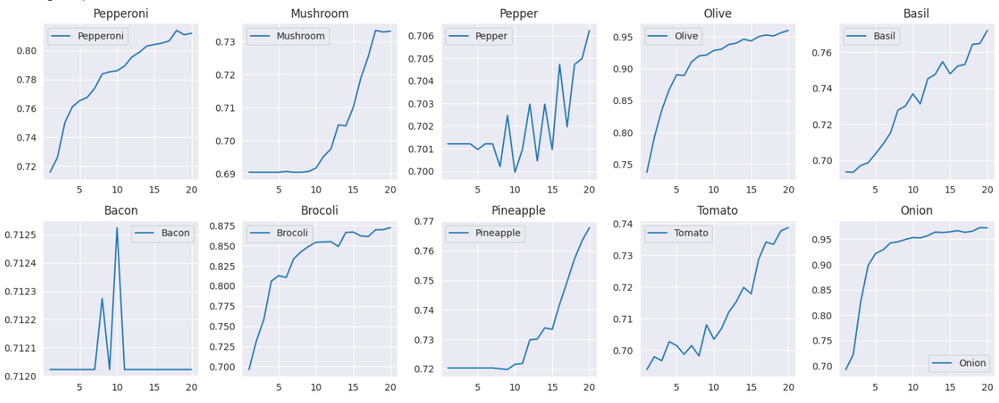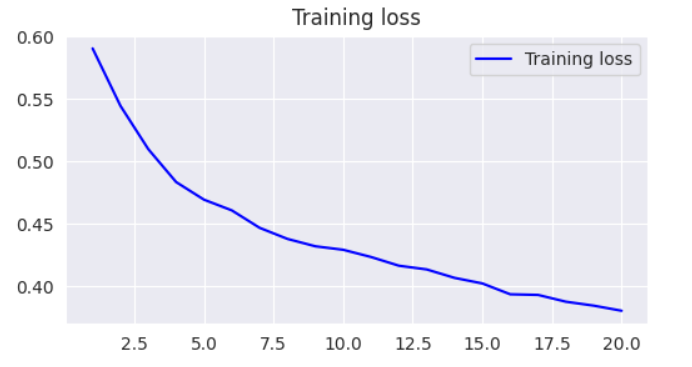

input_size=32

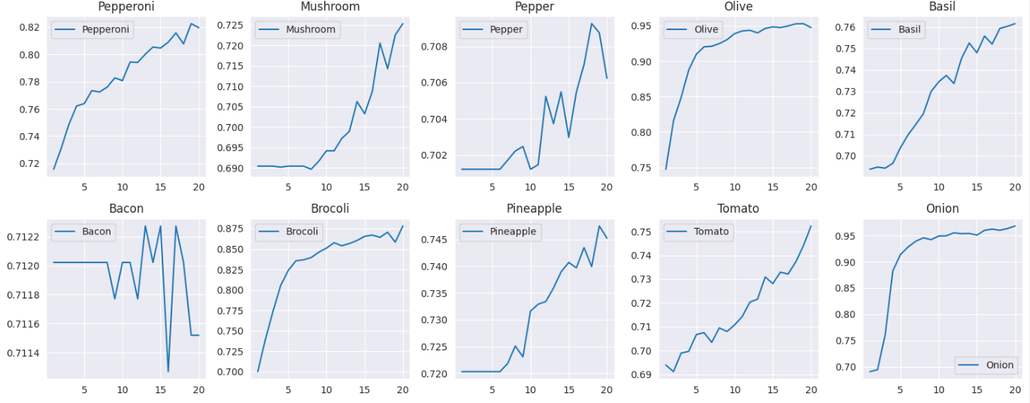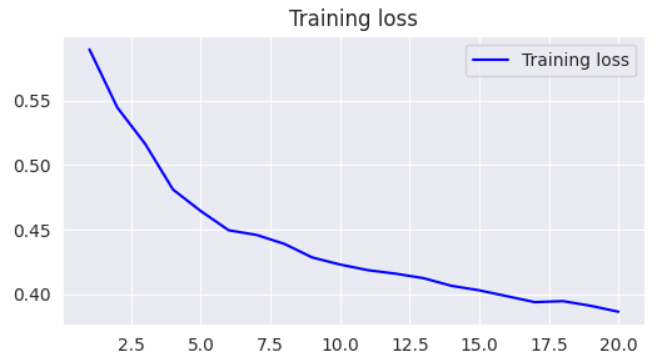

Input_size=224

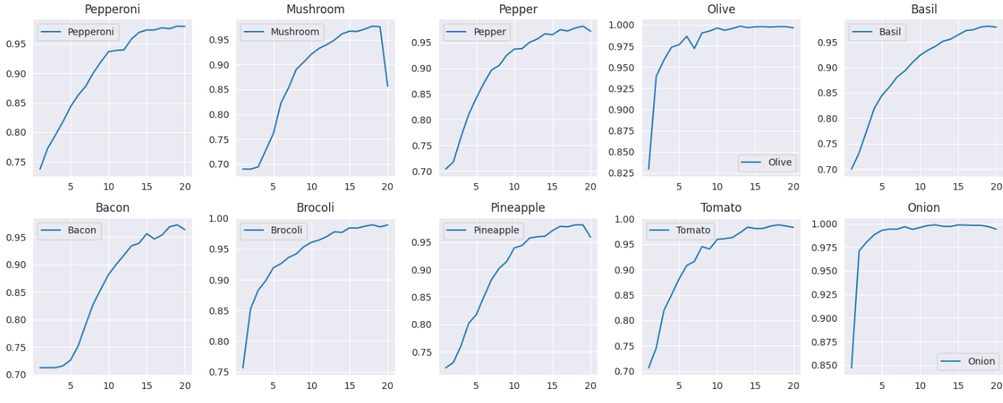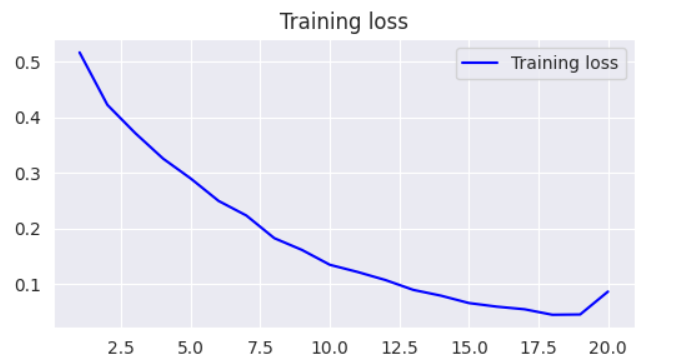

## Interprétation :

Lors de la variation de la taille d'entrée (**input_size**) de 32 à 224 dans le cadre de l'entraînement sans dropout, une taille d'entrée de 224 s'est avérée plus optimale. Cette observation est interprétée par la capacité accrue à capturer des détails fins dans les images, la réduction potentielle du sur-apprentissage, la meilleure généralisation à des données inconnues, et une convergence plus rapide vers une précision plus élevée. Ces avantages, associés à une taille d'entrée plus grande, suggèrent que le modèle bénéficie de la richesse d'informations contenues dans des images de taille 224, justifiant ainsi le choix de cette taille d'entrée pour une performance optimale du modèle.







**Training with droupout**

Dropout(p=0.2) input_size=32

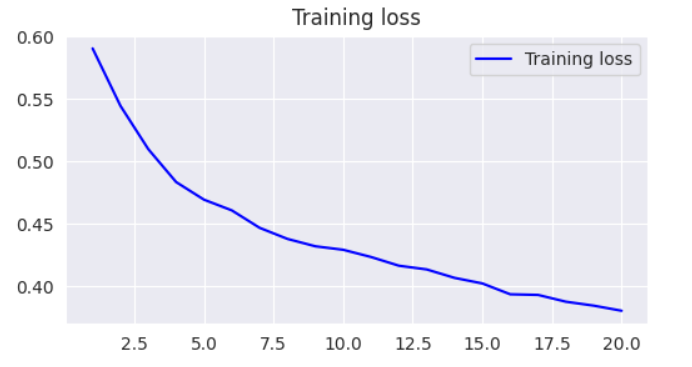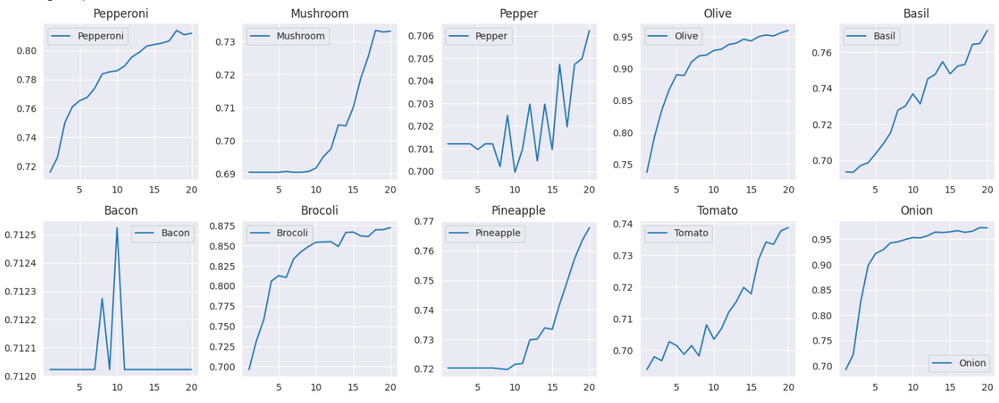

p=0.5 input_size=32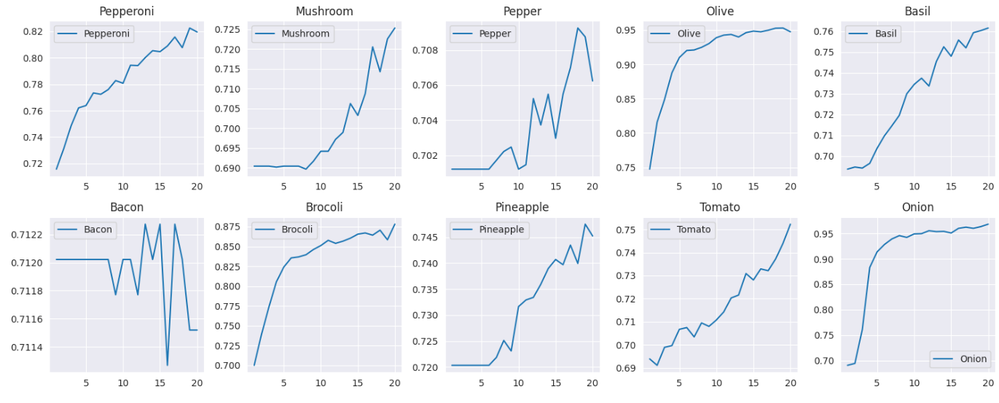

p=0.2 et input_size=224

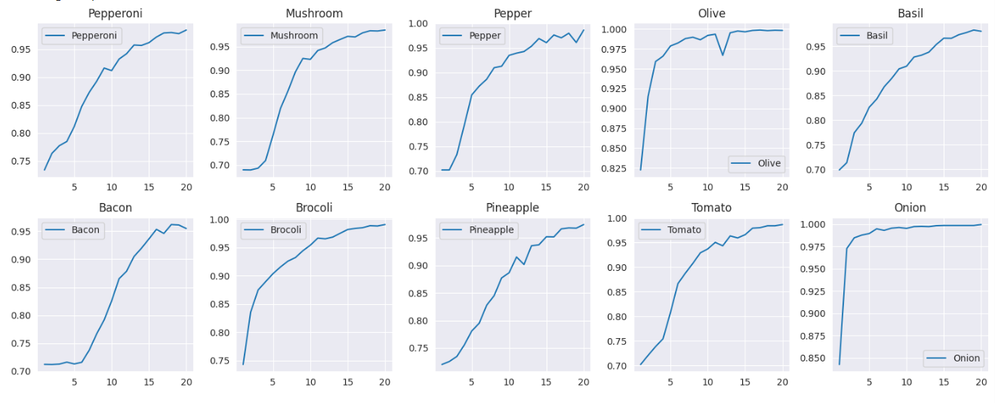

p=0.5 et input_size= 224

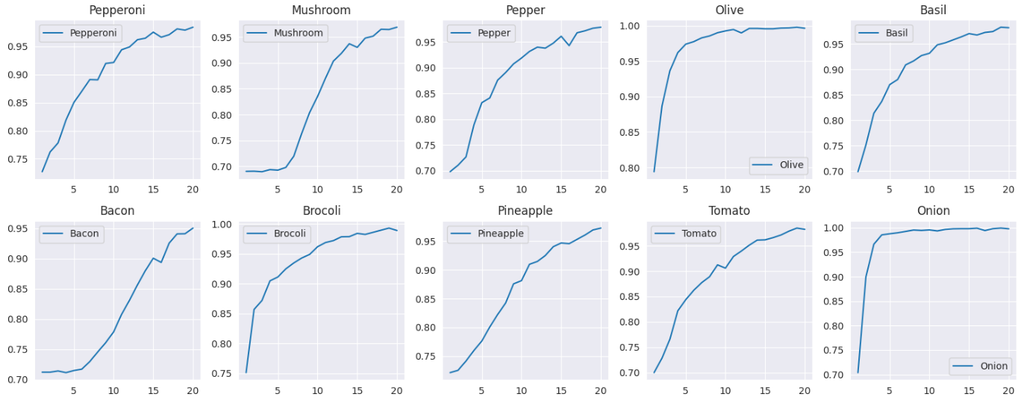

## Interprétation:

Lors de l'ajout du dropout pendant l'entraînement, une variation des valeurs de la probabilité de dropout (p) entre 0.2, 0.5 et 0.7 a été réalisée, tout en variant également la taille d'entrée (input_size). Les courbes d'apprentissage ont montré des comportements différents en fonction de la probabilité de dropout. Une probabilité de dropout de 0.2 a conduit à des courbes plus stables avec une convergence rapide, indiquant une régularisation légère du modèle. En revanche, des valeurs plus élevées de probabilité de dropout (0.5 et 0.7) ont montré des fluctuations plus prononcées dans les courbes, indiquant une régularisation plus forte, ce qui aide à prévenir le surapprentissage mais nécessite plus d'époques pour converger. La taille d'entrée optimale semble également jouer un rôle crucial, affectant la vitesse de convergence et la stabilité du modèle. Ces observations soulignent l'importance de l'équilibre entre régularisation (avec le dropout) et la richesse d'informations (avec une taille d'entrée plus grande) pour atteindre des performances optimales du modèle.

# Test without dropout

Lors des **test without dropout** en faisant varier la taille d'entrée (input_size) entre 32 et 224, il a été observé que la taille d'entrée de 224 a donné les meilleures performances. Théoriquement, la taille d'entrée d'un réseau de **neurones convolutif (CNN)** influe sur la taille des filtres, la résolution spatiale, et par conséquent, sur la capacité du modèle à extraire des caractéristiques discriminantes.la résolution spatiale d'une image en sortie de chaque couche de convolution est calculée à l'aide de formule:

$$\text{taille_sortie} = \frac{\text{taille_entrée} - \text{taille_filtre} + 2 \times \text{padding}}{\text{stride}} + 1$$

 Ainsi, une taille d'entrée plus grande permet au modèle de capturer des informations plus riches et d'obtenir une résolution spatiale plus élevée, améliorant sa capacité à discriminer entre différentes caractéristiques. pratiquement, cela se traduit par une meilleure représentation des objets complexes dans les images. En revanche, une taille d'entrée plus petite (32) conduit à une résolution spatiale plus basse, entraînant une perte de détails importants et limitant la capacité du modèle à généraliser correctement sur des données inconnues. Ainsi, ces résultats soulignent l'importance de la taille d'entrée dans la capacité du modèle à apprendre des caractéristiques discriminantes.

# Test with dropout

**Analyse des Performances du Modèle avec Variation de \(p\) et \(input\_size\)**

La variation de la probabilité de dropout (p) et de la taille d'entrée (input_size) dans un modèle CNN a des implications importantes sur son comportement et ses performances. Examinons ces aspects de manière approfondie :

1. **Effet de la Taille d'Entrée (input_size) :**

   La taille d'entrée influence directement le nombre total de paramètres du modèle, ce qui affecte sa capacité à capturer des motifs complexes. Soit (P) le nombre total de paramètres, (C) le nombre de canaux, (K) la taille du noyau, et (L) le nombre de couches. La formule pour (P) est :

  $$ [ P = C_1 \times K_1^2 \times L_1 + C_2 \times K_2^2 \times L_2 + \ldots + C_L \times K_L^2 \times L_L ]$$

   - **Meilleur Cas (input_size = 224) :** Une taille d'entrée plus grande permet au modèle de capturer des informations riches, améliorant potentiellement les performances.

   - **Pire Cas (input_size = 32) :** Une taille d'entrée plus petite  entraîne une perte d'informations, limitant la capacité du modèle à détecter des motifs complexes et conduisant à une sous-représentation des données.

2. **Effet de la Probabilité de Dropout (p) :**

   La probabilité de dropout ($p$) influe sur la régularisation du modèle en désactivant aléatoirement des neurones pendant l'entraînement. Cela prévient le surapprentissage. Soit ($x_i$) la sortie d'un neurone avant dropout, ($y_i$) la sortie après dropout, et ($p_i$) la probabilité de dropout du neurone ($i$). La formule pour le dropout est donnée par :

   $$ y_i = \frac{x_i}{1 - p_i} $$

   - **Meilleur Cas (p = 0.2) :** Une probabilité de dropout modérée offre une régularisation efficace sans désactiver excessivement les neurones, permettant ainsi un meilleur apprentissage des caractéristiques.

   - **Pire Cas (p = 0.7) :** Une probabilité de dropout trop élevée entraîne une désactivation excessive de neurones, entravant significativement la capacité du modèle à apprendre des motifs utiles.

3. **Sélection de la Configuration Optimale :**

   Pour atteindre des performances optimales, il est essentiel de trouver un équilibre entre la taille d'entrée, la probabilité de dropout et la complexité du modèle. Une configuration appropriée doit éviter le surapprentissage (trop de paramètres, `input_size` trop grand) et le sous-ajustement (trop petite `input_size`). Un compromis judicieux entre $p$ et `input_size` devrait être recherché pour maximiser la généralisation du modèle(dans notre modèle les meilleurs paramétres sont: p=0.2 et input_size=224).

**En conclusion,** l'analyse mathématique souligne l'importance de choisir une configuration adaptée aux données et à la complexité du modèle pour atteindre des performances optimales tout en évitant le surapprentissage et le sous-ajustement.



#Remarques finales

-Au cours de ce projet, plusieurs défis ont été rencontrés. La première difficulté était liée au partage de tâches, car l'environnement Google Colab ne prend pas en charge le partage de session en temps réel, rendant la collaboration plus complexe. De plus, les limitations d'utilisation du GPU dans Google Colab ont parfois ralenti le processus d'entraînement du modèle. L'insertion et l'interprétation des images dans le code ont également présenté des défis, nécessitant une gestion minutieuse de l'entrée des données. En outre, l'alignement du code avec les concepts théoriques a demandé une attention particulière. Enfin, la gestion du temps pour chaque étape du projet s'est avérée cruciale pour respecter les échéances.

-Le critère (criterion) choisi "BCEWithLogitsLoss" est une fonction de perte utilisée pour les problèmes de classification binaire. Elle prend en entrée les valeurs brutes du modèle (logits) avant la fonction d'activation, les transforme en probabilités à l'aide d'une sigmoïde, puis calcule la perte d'entropie croisée binaire entre ces probabilités et les étiquettes réelles. Cette fonction combine la transformation des logits et le calcul de la perte en un seul processus, simplifiant ainsi l'entraînement du modèle pour les tâches de classification binaire.


#Conclusion

En conclusion, ce projet a été une exploration passionnante du domaine de l'apprentissage profond appliqué à la classification d'images. Nous avons développé un modèle de réseau de neurones convolutif (CNN) capable de traiter des images de taille 224x224 avec une architecture adaptée. Nous avons également abordé des concepts importants tels que le dropout pour la régularisation du modèle et la BCEWithLogitsLoss comme fonction de perte pour la classification multi-label. Les défis rencontrés, tels que la gestion du partage de sessions sur Colab et l'intégration des images, ont renforcé notre compréhension des aspects pratiques de l'apprentissage profond. En dépit de ces difficultés, l'expérience globale a été enrichissante, mettant en lumière l'importance de l'ingénierie des données, du prétraitement et de l'ajustement des hyperparamètres pour obtenir des modèles performants. Ce projet a jeté les bases d'une compréhension approfondie des techniques avancées d'apprentissage profond pour la classification d'images.